In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

class Forward:
    def __init__(self, L, N, s, migration_matrix, tfinal, seed=None, l0=0):
        assert len(migration_matrix) == L, "Migration matrix size must match the number of demes"
        for j in range(L):
            assert len(migration_matrix[j]) == L, "Migration matrix must be square"
            assert migration_matrix[j][j] == 0, "Diagonal elements must be 0"
        
        self.L = int(L)  # Total number of demes
        self.N = int(N)  # Number of individuals in each deme
        self.s = s
        self.migration_matrix = migration_matrix
        self.tfinal = int(tfinal)
        self.l0 = int(l0)

        # Set the seed
        if seed is None:
            self.seed = random.randint(0, 1000000)
        else:
            self.seed = seed
        np.random.seed(self.seed)  # Setting the random seed
        print('seed:',self.seed)

    def next_gen(self, n):
        # Initialize the result array for the next generation
        next_gen_population = np.zeros(self.L)

        # Calculate the initial allele counts in each deme
        initial_allele_counts = np.array(n)
        # print('Initial allele counts:', initial_allele_counts)

        # Initialize arrays for relative allele counts after migration and new population sizes
        migrated_allele_counts = np.zeros(self.L)
        new_population_size = np.zeros(self.L) + 1

        # Apply migration using the migration matrix
        for i in range(self.L):
            migrated_allele_counts[i] = initial_allele_counts[i]
            for j in range(self.L):
                if i != j:
                    # Calculate influx and outflow of alleles
                    allele_influx = self.migration_matrix[i][j] * initial_allele_counts[j]
                    allele_outflow = self.migration_matrix[j][i] * initial_allele_counts[i]

                    # Update relative allele counts after migration
                    migrated_allele_counts[i] += allele_influx - allele_outflow

                    # Calculate influx and outflow of population
                    population_influx = self.migration_matrix[i][j]
                    population_outflow = self.migration_matrix[j][i]

                    # Update new population size
                    new_population_size[i] += population_influx - population_outflow

                    # print(f'Deme {i}: Allele influx from {j} = {allele_influx}, Allele outflow to {j} = {allele_outflow}')

                    # Check for negative population size
                    if new_population_size[i] <= 0:
                        raise Exception("DemeSize Can Not Be Negative or Zero")

        # print('New population sizes:', new_population_size)
        # print('Migrated allele counts:', migrated_allele_counts)


        # Calculate the allele count for the next generation
        for i in range(self.L):
            # Calculate new frequency based on migrated allele counts and new population size
            new_freq = migrated_allele_counts[i] / (new_population_size[i]* self.N)
            # Apply selection effect
            selected_freq = new_freq + self.s * new_freq * (1 - new_freq)
            selected_freq = min(selected_freq, 1)  # Ensure frequency does not exceed 1
            # print('Deme', i, 'selected frequency is', selected_freq)

            # Calculate the next generation population based on selected frequency
            next_gen_population[i] = np.random.binomial(self.N , selected_freq)

        return next_gen_population




    def forward(self):
        # Initialize a list to store the allele frequencies over time
        result = []

        # Initialize the population array with zeros
        n = np.zeros(self.L)

        # Introduce a mutant at the first deme
        n[self.l0] = 1

        # Initialize the time counter
        t = 0

        # Run the simulation until a successful sweep or until 'tfinal' time steps
        while t < self.tfinal:
            ntot = sum(n)
            # print(f"Generation {t}: n = {n}, Total = {ntot}")

            # Check if the beneficial allele has gone extinct
            if ntot == 0:
                print("Beneficial allele extinct, reintroducing...")
                # Reintroduce the beneficial allele at the first deme
                n = np.zeros(self.L)
                n[self.l0] = 1
                # Optionally, reset the result list if you want to start fresh
                result = []
                # Reset the time counter
                t = 0
            elif ntot >= 1 * self.N * self.L:
                # A significant portion of the population has the beneficial allele; end the simulation
                result.extend(n)
                t += 1
                break
            elif t == self.tfinal:
                print("Reach tfinal, reintroducing...")
                # Reintroduce the beneficial allele at the first deme
                n = np.zeros(self.L)
                n[self.l0] = 1
                # Optionally, reset the result list if you want to start fresh
                result = []
                # Reset the time counter
                t = 0                
            # Record the current state and calculate the next generation
            result.extend(n)
            n = self.next_gen(n)

            # Increment the time counter
            t += 1

        return result



In [3]:

# As described in the Definitions section, 
# continuous migration between populations is modelled by a matrix of rates,
# so that M[i, j] is the rate at which lineages move from population i to population j in the coalescent process, 
# that is, backwards in time (see the Direction of time section for more details). 
# Lineages that move from population i to j backwards in time 
# actually correspond to individuals migrating from population j to i forwards in time.

class MigrationMatrixGenerator:
    def __init__(self, deme_dimension, migration_rate):
        self.deme_dimension = deme_dimension
        self.migration_rate = migration_rate
    

    def generate_1Dmatrix(self):
        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            if i > 0:
                M[i, i - 1] = self.migration_rate
            if i < self.deme_dimension - 1:
                M[i, i + 1] = self.migration_rate

        return M
    
    
    def generate_2Dmatrix(self):
        """
        Generates a 2D migration matrix for a square grid of demes.
        Each deme can migrate to its immediate neighbors (up, down, left, right).
        Diagonal elements are set to 0, indicating no self-migration.
        """
        z = math.sqrt(self.deme_dimension)
        if not z.is_integer():
            raise ValueError("Deme dimension must be a perfect square for a 2D grid.")
        z = int(z)

        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            for j in range(self.deme_dimension):
                # Check for right neighbor
                if j == i + 1 and (i + 1) % z != 0:
                    M[i, j] = self.migration_rate
                # Check for down neighbor
                elif j == i + z and j < self.deme_dimension:
                    M[i, j] = self.migration_rate

                # Ensure migration is bidirectional
                M[j, i] = M[i, j]

        return M

    def generate_3Dmatrix(self):
        """
        Generates a 3D migration matrix for a cubic grid of demes.
        Each deme can migrate to its immediate neighbors along the x, y, and z axes.
        Diagonal elements are set to 0, indicating no self-migration.
        """
        cube_root = round(self.deme_dimension ** (1/3))
        if cube_root ** 3 != self.deme_dimension:
            raise ValueError("Deme dimension must be a cube number for a 3D grid.")

        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            x, y, z = np.unravel_index(i, (cube_root, cube_root, cube_root))

            # Check neighbors in each direction (left, right, up, down, front, back)
            for dx, dy, dz in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]:
                nx, ny, nz = x + dx, y + dy, z + dz
                if 0 <= nx < cube_root and 0 <= ny < cube_root and 0 <= nz < cube_root:
                    neighbor_index = np.ravel_multi_index((nx, ny, nz), (cube_root, cube_root, cube_root))
                    M[i, neighbor_index] = self.migration_rate

        return M

    def generate_island_model_matrix(self):
        """
        Generates a migration matrix based on the island model.
        Each deme has an equal migration rate to every other deme.
        Diagonal elements are set to 0, indicating no self-migration.
        """
        M = np.full((self.deme_dimension, self.deme_dimension), self.migration_rate)
        np.fill_diagonal(M, 0)  # Set diagonal elements to 0
        return M    

In [4]:
class DeterministicTrajectorySimulator:
    def __init__(self, L, N, frequencies):
        self.L = L  # Total number of demes
        self.N = N  # Number of individuals in each deme
        self.frequencies = frequencies  # List of allele frequencies over time

        # Validate frequencies length to be a multiple of L
        if len(frequencies) % L != 0:
            raise ValueError("Length of frequencies must be a multiple of the number of demes (L)")

        self.end_time = len(frequencies) // L  # Total duration of the simulation in generations
        self.timestep = 1.0 / self.N  # Rescaled timestep for backward simulation

    def simulate(self):
            time = []  # List to store time points
            allele_freqs = []  # List to store allele frequencies

            forwards_t = 0  # Forward time in generations
            backwards_t = 0  # Backward time in rescaled units
            position = len(self.frequencies) - self.L  # Start from the last generation of the first deme

    #Go back for the entire duration of the sweep
            while forwards_t < self.end_time:
                for deme in range(self.L):
                    deme_pos = position + deme
                    allele_freqs.append(float(self.frequencies[deme_pos]) / self.N)
    
                # Update time lists
                time.append(backwards_t)
                forwards_t += 1 #Forward time is in units of generations.
                backwards_t += self.timestep  # Increment backward time
                position -= self.L #In each single timestep, we handle L positions. Skip back L positions for the next timestep.
            
            return time, allele_freqs
    
    def write_results_to_file(self, filename="simulation_results.txt"):
        with open(filename, 'w') as file:
            # Write the number of demes (L) on the first line
            file.write(f"{self.L}\n")
            
            # Calculate the number of timesteps
            num_timesteps = len(self.frequencies) // self.L
            
            # Initialize time counter
            time_counter = 0
            
            # Write the sweep trajectories
            for t in range(0, len(self.frequencies), self.L):
                # Extract the frequencies for this timestep across all demes
                timestep_frequencies = self.frequencies[t:t+self.L]
                
                # Format the line to write: time followed by frequencies separated by tabs
                line = f"{time_counter}\t" + "\t".join(map(str, timestep_frequencies)) + "\n"
                
                # Write the formatted line to the file
                file.write(line)
                
                # Increment the time counter
                time_counter += 1


In [5]:

# Parameters for the Forward simulation
N = 2000  # Number of individuals in each deme
s = 0.25  # Selection coefficient
tfinal = 200  # Number of generations
seed = 40  # Random seed
L = 25  # For a L Number of demes
migration_rate = 1/L
generator = MigrationMatrixGenerator(L, migration_rate)
migration_matrix = generator.generate_island_model_matrix()

# # Define a simple 3x3 migration matrix for 3 demes
# migration_matrix = np.array([
#     [0, 0.15, 0],
#     [0.15, 0, 0],
#     [0, 0.15, 0]
# ])

# L = 3  # Number of demes




# Create an instance of the Forward class and run the simulation
forward_sim = Forward(L, N, s, migration_matrix, tfinal)
frequencies = forward_sim.forward()

# Now, use the output in DeterministicTrajectorySimulator
simulator = DeterministicTrajectorySimulator(L, N, frequencies)
time, allele_freqs = simulator.simulate()

# Print the results for verification
# print("Time:", time)
# print("Allele Frequencies:", allele_freqs)

seed: 40603


[[1.e+00 1.e+00 1.e+00 ... 1.e+00 1.e+00 1.e+00]
 [1.e+00 1.e+00 1.e+00 ... 1.e+00 1.e+00 1.e+00]
 [1.e+00 1.e+00 1.e+00 ... 1.e+00 1.e+00 1.e+00]
 ...
 [5.e-04 0.e+00 0.e+00 ... 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 ... 0.e+00 0.e+00 0.e+00]
 [5.e-04 0.e+00 0.e+00 ... 0.e+00 0.e+00 0.e+00]]


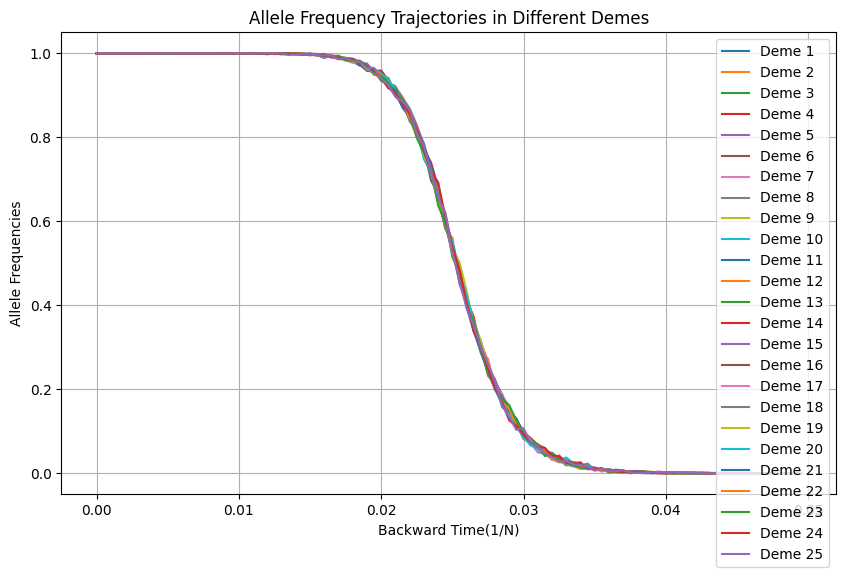

In [6]:

# Assuming 'time' is a list of time points and 'allele_freqs' is a list of allele frequencies
# with each deme's frequencies in sequence.

# Reshape allele_freqs to have columns, one for each deme
allele_freqs_reshaped = np.array(allele_freqs).reshape(-1, L)
print(allele_freqs_reshaped)

# Plotting
plt.figure(figsize=(10, 6))
for i in range(L):
    plt.plot(time, allele_freqs_reshaped[:, i], label=f'Deme {i+1}')

plt.xlabel('Backward Time(1/N)')
plt.ylabel('Allele Frequencies')
plt.title('Allele Frequency Trajectories in Different Demes')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
import os

filename = "sweep_trajectories.txt"
if os.path.exists(filename):
    print(f"Error: The file '{filename}' already exists. Choose a different name or remove the existing file.")
else:
    # Write the results to a file
    simulator.write_results_to_file("sweep_trajectories.txt")

AttributeError: 'DeterministicTrajectorySimulator' object has no attribute 'write_results_to_file'